<a href="https://colab.research.google.com/github/GemmaGorey/Dissertation/blob/main/Dissertation_model_training_basic_VGGish_V1_2_MODEL_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
# install mamba to use instead of pip

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:07
🔁 Restarting kernel...


In [ ]:
# Create the config file and build the environment.
yaml_content = """
name: dissertation
channels:
  - pytorch
  - conda-forge
dependencies:
  - python=3.11
  - pytorch=2.2.2
  - torchvision=0.17.2
  - torchaudio
  - librosa
  - numpy<2
  - pandas
  - jupyter
  - wandb
"""

# Write the string content to a file -  'environment.yml'.
with open('environment.yml', 'w') as f:
    f.write(yaml_content)

print("environment.yml file created successfully.")

# create the environment using mamba from the yml file.
print("\n Creating environment")

!mamba env create -f environment.yml --quiet && echo -e "\n 'dissertation' environment is ready to use."

environment.yml file created successfully.

 Creating environment
Channels:
 - pytorch
 - conda-forge
Platform: linux-64
Solving environment: ...working... done
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

 'dissertation' environment is ready to use.


In [ ]:
# imports and setting up of GitHub and W&B

# clone project repository from GitHub
print("⏳ Cloning GitHub repository...")
!git clone https://github.com/GemmaGorey/Dissertation.git
print("Repository cloned.")

#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#imports
import pandas as pd
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from transformers import AutoTokenizer
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import AutoModel
import torch.optim as optim
import wandb
import subprocess

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased') #loading the tokenizer for lyrics processing
print("Tokenizer loaded.")

⏳ Cloning GitHub repository...
Cloning into 'Dissertation'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 124 (delta 59), reused 5 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (124/124), 734.04 KiB | 9.06 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Repository cloned.
Mounted at /content/drive
Loading tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer loaded.


In [ ]:
class MER_Dataset(Dataset):
    """ Custom PyTorch Dataset for loading MER data. """
    def __init__(self, annotations_df, tokenizer):
        """ Creation of the Dataset from the dataframe (predefined splits in MERGE dataset) """
        self.annotations = annotations_df
        self.tokenizer = tokenizer

    def __len__(self):
        """
        Function to return the total number of songs in the dataset.
        """
        return len(self.annotations)

    def __getitem__(self, index):
        """
        Function to get a song from the dataset.
        """
        song_info = self.annotations.iloc[index] #which song ID/row is picked from the dataset as per the index

        spectrogram_path = song_info['spectrogram_path'] # columns from the df
        lyrics_path = song_info['lyrics_path'] # columns from the df
        valence = song_info['valence'] # columns from the df
        arousal = song_info['arousal'] # columns from the df

        #change spectorgram into a tensor
        spectrogram = np.load(spectrogram_path) #loading spectorgram from path saved in df
        spectrogram_tensor = torch.from_numpy(spectrogram).float() # changing the np array to tensor
        spectrogram_tensor = spectrogram_tensor.unsqueeze(0) #Adding a "channel" dimension for CNN

        #Load the lyric tokens
        encoded_lyrics = torch.load(lyrics_path, weights_only=False)
        input_ids = encoded_lyrics['input_ids'].squeeze(0) #remove the batch dimension from input ids so 1d array
        attention_mask = encoded_lyrics['attention_mask'].squeeze(0) #remove the batch dimension from attention mask so 1d

        labels = torch.tensor([valence, arousal], dtype=torch.float32) # extract labels

        return spectrogram_tensor, input_ids, attention_mask, labels

In [ ]:
class AttentionModule(nn.Module): #Addition from V1
    def __init__(self, feature_dim):
        super(AttentionModule, self).__init__()
        '''
        Attention mechanism to weight the importance of different features
        '''
        self.attention = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 4),  # input is 64 will map to16
            nn.ReLU(),
            nn.Linear(feature_dim // 4, feature_dim),  #reverts back to 64 from 16
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: [batch_size, 64]
        attention_weights = self.attention(x)  # [batch_size, 64]
        weighted_features = x * attention_weights  # Element-wise multiplication
        return weighted_features

In [ ]:
class VGGish_Audio_Model(nn.Module):
    '''As previous vERSION but adding in the following
      - Batch normalisation
      - Attention mechanism
      - Learning rate scheduling
      - early stopping'''

    def __init__(self):
        super(VGGish_Audio_Model, self).__init__()
        '''
        A VGG-style model for the audio tower for a starting model.
        No longer trying to implement the method from MERGE paper as this had mistakes in the paper
        V1.1 includes attention to see if this improves performance.
        V1.2  implements true VGG-style blocks with multiple convolutions per block.
        '''
        self.features = nn.Sequential(
            # Block 1 - 2 convolutions
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2 - 2 convolutions
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3 - 2 convolutions
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4 - 2 convolutions
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 64) # Final feature vector size should be 64 - needs to match input of combined
        )

        self.attention = AttentionModule(64) #Addition from V1

    def forward(self, x):
        x = self.features(x)
        # Flatten the features for the classifier
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = self.attention(x) #Addition from V1
        return x

In [ ]:
class BimodalClassifier(nn.Module):
    """
    The final bimodal model. No longer using MERGE archtecture as
    transformer would be better. Also due to mistakes in the paper it is
    unclear what some of the parameters are.
    """
    def __init__(self):
        super(BimodalClassifier, self).__init__()

        #initiate audio tower
        self.audio_tower = VGGish_Audio_Model()

        #use transformer for lyrics (using bert base uncased for now, but may change)
        self.lyrics_tower = AutoModel.from_pretrained('bert-base-uncased')
        for param in self.lyrics_tower.parameters():
            param.requires_grad = False

        # Define feature sizes from the previous step and from bert
        AUDIO_FEATURES_OUT = 64
        LYRICS_FEATURES_OUT = 768
        COMBINED_FEATURES = AUDIO_FEATURES_OUT + LYRICS_FEATURES_OUT

        self.classifier_head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=COMBINED_FEATURES, out_features=100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=100, out_features=2) # 2 Outputs for Valence and Arousal
        )

    def forward(self, x_audio, input_ids, attention_mask):
        #process audio input
        audio_features = self.audio_tower(x_audio)

        #get lyric features
        lyrics_outputs = self.lyrics_tower(input_ids=input_ids, attention_mask=attention_mask)

        #use the embedding of the [CLS] token as the feature vector for whole lyrics
        lyrics_features = lyrics_outputs.last_hidden_state[:, 0, :]

        #combine the features from both towers
        combined_features = torch.cat((audio_features, lyrics_features), dim=1)

        #pass the combined features to the final classifier head
        output = self.classifier_head(combined_features)

        return output

In [ ]:
#Data loading and prep

#get the paths to dissertation folder and new folder on colab
print("Starting data transfer from Google Drive to local Colab storage...")

#get paths for old file location and new colab one
gdrive_zip_path = '/content/drive/MyDrive/dissertation/merge_dataset_zipped.zip'
local_storage_path = '/content/local_dissertation_data/'
local_zip_path = os.path.join(local_storage_path, 'merge_dataset_zipped.zip')
os.makedirs(local_storage_path, exist_ok=True) # Ensure the destination directory exists

#Copy zip file from Drive to Colab
print("Copying single archive file from Google Drive...")
!rsync -ah --progress "{gdrive_zip_path}" "{local_storage_path}"

#get total number of files for progress
total_files = int(subprocess.check_output(f"zipinfo -1 {local_zip_path} | wc -l", shell=True))

#unzip the file
print("Extracting files locally")
!unzip -o "{local_zip_path}" -d "{local_storage_path}" | tqdm --unit=files --total={total_files} > /dev/null

print("Data transfer and extraction complete.")

#load master data from new location
local_output_path = os.path.join(local_storage_path, 'merge_dataset/output_from_code/')
master_file_path = os.path.join(local_output_path, 'master_processed_file_list.csv')
master_df = pd.read_csv(master_file_path)

#checking the valence and arousal range in the dataset
print(f"\nValence range in data: [{master_df['valence'].min()}, {master_df['valence'].max()}]")
print(f"Arousal range in data: [{master_df['arousal'].min()}, {master_df['arousal'].max()}]")
print(f"Valence mean: {master_df['valence'].mean():.4f}, std: {master_df['valence'].std():.4f}")
print(f"Arousal mean: {master_df['arousal'].mean():.4f}, std: {master_df['arousal'].std():.4f}")
print(f"Total samples in master_df: {len(master_df)}")

# Verify its the right column - not quadrants
print(f"\nNumber of unique valence values: {master_df['valence'].nunique()}")
print(f"Number of unique arousal values: {master_df['arousal'].nunique()}")
print(f"Number of unique quadrant values: {master_df['quadrant'].nunique()}")

# Sample some actual values
print(f"\nSample valence values: {master_df['valence'].sample(10).values}")
print(f"Sample arousal values: {master_df['arousal'].sample(10).values}")

#update the paths in the csv
print("\nUpdating dataframe paths to use fast local storage...")
gdrive_output_path = '/content/drive/MyDrive/dissertation/output_from_code/'
master_df['spectrogram_path'] = master_df['spectrogram_path'].str.replace(gdrive_output_path, local_output_path, regex=False)
master_df['lyrics_path'] = master_df['lyrics_path'].str.replace(gdrive_output_path, local_output_path, regex=False)
print("Dataframe paths updated.")

#load the data splits from the new path in the predefined splits folder tvt
local_split_folder_path = os.path.join(local_storage_path, 'merge_dataset/MERGE_Bimodal_Complete/tvt_dataframes/tvt_70_15_15/')
train_split_df = pd.read_csv(os.path.join(local_split_folder_path, 'tvt_70_15_15_train_bimodal_complete.csv'))
val_split_df = pd.read_csv(os.path.join(local_split_folder_path, 'tvt_70_15_15_validate_bimodal_complete.csv'))
test_split_df = pd.read_csv(os.path.join(local_split_folder_path, 'tvt_70_15_15_test_bimodal_complete.csv'))
print("\nSplit files loaded from local storage.")

#merge the files
id_column_name = 'song_id'
train_split_df.rename(columns={'Song': id_column_name}, inplace=True)
val_split_df.rename(columns={'Song': id_column_name}, inplace=True)
test_split_df.rename(columns={'Song': id_column_name}, inplace=True)

train_df = pd.merge(master_df, train_split_df, on=id_column_name)
val_df = pd.merge(master_df, val_split_df, on=id_column_name)
test_df = pd.merge(master_df, test_split_df, on=id_column_name)

#checking no files are lost in merging - and checking length of the dataframes.
print("\nchecking data")

#check no data lost in merge
if len(train_df) == len(train_split_df):
    print("\nTraining split: Merge successful. All songs accounted for.")
else:
    print(f"\nWARNING: Training split lost {len(train_split_df) - len(train_df)} songs during merge.")

if len(val_df) == len(val_split_df):
    print("Validation split: Merge successful. All songs accounted for.")
else:
    print(f"WARNING: Validation split lost {len(val_split_df) - len(val_df)} songs during merge.")

if len(test_df) == len(test_split_df):
    print("Test split: Merge successful. All songs accounted for.")
else:
    print(f"WARNING: Test split lost {len(test_split_df) - len(test_df)} songs during merge.")

#check length
expected_train_len = 1552
expected_val_len = 332
expected_test_len = 332

assert len(train_df) == expected_train_len, f"Expected {expected_train_len} training samples, but found {len(train_df)}"
assert len(val_df) == expected_val_len, f"Expected {expected_val_len} validation samples, but found {len(val_df)}"
assert len(test_df) == expected_test_len, f"Expected {expected_test_len} test samples, but found {len(test_df)}"

print(f"\nFinal dataset lengths are correct: Train({len(train_df)}), Val({len(val_df)}), Test({len(test_df)})")
print("Data Check Complete")

#createthe datasets and loaders
train_dataset = MER_Dataset(annotations_df=train_df, tokenizer=tokenizer)
val_dataset = MER_Dataset(annotations_df=val_df, tokenizer=tokenizer)
test_dataset = MER_Dataset(annotations_df=test_df, tokenizer=tokenizer)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\nDataLoaders created successfully.")

Starting data transfer from Google Drive to local Colab storage...
Copying single archive file from Google Drive...
sending incremental file list
merge_dataset_zipped.zip
          1.23G 100%   99.97MB/s    0:00:11 (xfr#1, to-chk=0/1)
Extracting files locally
4442files [00:15, 290.05files/s]           
Data transfer and extraction complete.

Valence range in data: [0.0187499999999999, 0.9875]
Arousal range in data: [0.0625, 0.975]
Valence mean: 0.5050, std: 0.2311
Arousal mean: 0.4823, std: 0.1395
Total samples in master_df: 2216

Number of unique valence values: 465
Number of unique arousal values: 443
Number of unique quadrant values: 4

Sample valence values: [0.765    0.22625  0.305    0.30625  0.871875 0.3675   0.19125  0.8375
 0.6875   0.73625 ]
Sample arousal values: [0.6375   0.620625 0.624375 0.465    0.555625 0.29     0.56125  0.599375
 0.39125  0.314375]

Updating dataframe paths to use fast local storage...
Dataframe paths updated.

Split files loaded from local storage.

c

In [ ]:
# Check if a CUDA-enabled GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using CUDA device.")
else:
    # If no GPU is found, print an error and stop execution by raising an error.
    raise RuntimeError("Error: No GPU found. This script requires a GPU to run.")


GPU is available. Using CUDA device.


In [ ]:
#Final output model
model = BimodalClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss() # Using Mean Squared Error for regression

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5) #Addition from V1

#training
wandb.init(project="dissertation-mer-regression")

# Early Stopping Setup - Addition from V1
best_val_loss = float('inf') #Addition from V1
patience = 10  # Stop if no improvement for 10 epochs Addition from V1
patience_counter = 0 #Addition from V1
best_model_state = None #Addition from V1

NUM_EPOCHS = 50

for epoch in range(NUM_EPOCHS):
    #training
    model.train()
    total_train_loss = 0

    for spectrogram_batch, input_ids_batch, attention_mask_batch, labels_batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        spectrogram_batch = spectrogram_batch.to(device)
        input_ids_batch = input_ids_batch.to(device)
        attention_mask_batch = attention_mask_batch.to(device)
        labels_batch = labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(spectrogram_batch, input_ids_batch, attention_mask_batch)
        loss = loss_fn(outputs, labels_batch)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Average Training Loss: {avg_train_loss:.4f}")
    wandb.log({"epoch": epoch+1, "train_loss": avg_train_loss})

    #vaidate
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for spectrogram_batch, input_ids_batch, attention_mask_batch, labels_batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            spectrogram_batch = spectrogram_batch.to(device)
            input_ids_batch = input_ids_batch.to(device)
            attention_mask_batch = attention_mask_batch.to(device)
            labels_batch = labels_batch.to(device)

            outputs = model(spectrogram_batch, input_ids_batch, attention_mask_batch)
            loss = loss_fn(outputs, labels_batch)
            total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Average Validation Loss: {avg_val_loss:.4f}")
    wandb.log({"val_loss": avg_val_loss})

    # Early Stopping Logic - Addition from V1
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model state
        best_model_state = model.state_dict().copy()
        print(f"✓ New best validation loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs (patience: {patience})")

        if patience_counter >= patience:
            print(f"Early stopping triggered! Best validation loss: {best_val_loss:.4f}")
            # Restore the best model
            model.load_state_dict(best_model_state)
            break

    scheduler.step() # Addition from V1
    current_lr = scheduler.get_last_lr()[0] #Addition from V1
    print(f"Learning Rate: {current_lr:.6f}") #Addition from V1
    wandb.log({"learning_rate": current_lr}) #Addition from V1

if patience_counter >= patience:  #Addition from V1
    print("--- Training Stopped Early ---") #Addition from V1
    print(f"Best model restored from epoch {epoch + 1 - patience}") #Addition from V1
else:
    print("--- Training Completed All Epochs ---") #Addition from V1

print(f"Final best validation loss: {best_val_loss:.4f}") #Addition from V1
print("--- Pipeline Test Complete ---") #Addition from V1




model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gemwrigley (gemwrigley-university-of-bath) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training Epoch 1:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 1/50, Average Training Loss: 0.0615


Validation Epoch 1:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/50, Average Validation Loss: 0.0283
✓ New best validation loss: 0.0283
Learning Rate: 0.001000


Training Epoch 2:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 2/50, Average Training Loss: 0.0439


Validation Epoch 2:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2/50, Average Validation Loss: 0.0223
✓ New best validation loss: 0.0223
Learning Rate: 0.001000


Training Epoch 3:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 3/50, Average Training Loss: 0.0394


Validation Epoch 3:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3/50, Average Validation Loss: 0.0220
✓ New best validation loss: 0.0220
Learning Rate: 0.001000


Training Epoch 4:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 4/50, Average Training Loss: 0.0337


Validation Epoch 4:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4/50, Average Validation Loss: 0.0201
✓ New best validation loss: 0.0201
Learning Rate: 0.001000


Training Epoch 5:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 5/50, Average Training Loss: 0.0329


Validation Epoch 5:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5/50, Average Validation Loss: 0.0207
No improvement for 1 epochs (patience: 10)
Learning Rate: 0.001000


Training Epoch 6:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 6/50, Average Training Loss: 0.0313


Validation Epoch 6:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6/50, Average Validation Loss: 0.0294
No improvement for 2 epochs (patience: 10)
Learning Rate: 0.001000


Training Epoch 7:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 7/50, Average Training Loss: 0.0293


Validation Epoch 7:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7/50, Average Validation Loss: 0.0201
No improvement for 3 epochs (patience: 10)
Learning Rate: 0.001000


Training Epoch 8:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 8/50, Average Training Loss: 0.0285


Validation Epoch 8:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8/50, Average Validation Loss: 0.0238
No improvement for 4 epochs (patience: 10)
Learning Rate: 0.001000


Training Epoch 9:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 9/50, Average Training Loss: 0.0272


Validation Epoch 9:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9/50, Average Validation Loss: 0.0191
✓ New best validation loss: 0.0191
Learning Rate: 0.001000


Training Epoch 10:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 10/50, Average Training Loss: 0.0264


Validation Epoch 10:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10/50, Average Validation Loss: 0.0222
No improvement for 1 epochs (patience: 10)
Learning Rate: 0.001000


Training Epoch 11:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 11/50, Average Training Loss: 0.0255


Validation Epoch 11:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 11/50, Average Validation Loss: 0.0186
✓ New best validation loss: 0.0186
Learning Rate: 0.001000


Training Epoch 12:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 12/50, Average Training Loss: 0.0250


Validation Epoch 12:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 12/50, Average Validation Loss: 0.0179
✓ New best validation loss: 0.0179
Learning Rate: 0.001000


Training Epoch 13:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 13/50, Average Training Loss: 0.0243


Validation Epoch 13:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 13/50, Average Validation Loss: 0.0206
No improvement for 1 epochs (patience: 10)
Learning Rate: 0.001000


Training Epoch 14:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 14/50, Average Training Loss: 0.0245


Validation Epoch 14:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 14/50, Average Validation Loss: 0.0181
No improvement for 2 epochs (patience: 10)
Learning Rate: 0.001000


Training Epoch 15:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 15/50, Average Training Loss: 0.0236


Validation Epoch 15:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 15/50, Average Validation Loss: 0.0183
No improvement for 3 epochs (patience: 10)
Learning Rate: 0.000500


Training Epoch 16:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 16/50, Average Training Loss: 0.0224


Validation Epoch 16:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 16/50, Average Validation Loss: 0.0178
✓ New best validation loss: 0.0178
Learning Rate: 0.000500


Training Epoch 17:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 17/50, Average Training Loss: 0.0224


Validation Epoch 17:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 17/50, Average Validation Loss: 0.0171
✓ New best validation loss: 0.0171
Learning Rate: 0.000500


Training Epoch 18:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 18/50, Average Training Loss: 0.0227


Validation Epoch 18:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 18/50, Average Validation Loss: 0.0169
✓ New best validation loss: 0.0169
Learning Rate: 0.000500


Training Epoch 19:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 19/50, Average Training Loss: 0.0216


Validation Epoch 19:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 19/50, Average Validation Loss: 0.0170
No improvement for 1 epochs (patience: 10)
Learning Rate: 0.000500


Training Epoch 20:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 20/50, Average Training Loss: 0.0214


Validation Epoch 20:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 20/50, Average Validation Loss: 0.0175
No improvement for 2 epochs (patience: 10)
Learning Rate: 0.000500


Training Epoch 21:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 21/50, Average Training Loss: 0.0218


Validation Epoch 21:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 21/50, Average Validation Loss: 0.0214
No improvement for 3 epochs (patience: 10)
Learning Rate: 0.000500


Training Epoch 22:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 22/50, Average Training Loss: 0.0213


Validation Epoch 22:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 22/50, Average Validation Loss: 0.0166
✓ New best validation loss: 0.0166
Learning Rate: 0.000500


Training Epoch 23:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 23/50, Average Training Loss: 0.0220


Validation Epoch 23:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 23/50, Average Validation Loss: 0.0167
No improvement for 1 epochs (patience: 10)
Learning Rate: 0.000500


Training Epoch 24:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 24/50, Average Training Loss: 0.0214


Validation Epoch 24:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 24/50, Average Validation Loss: 0.0164
✓ New best validation loss: 0.0164
Learning Rate: 0.000500


Training Epoch 25:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 25/50, Average Training Loss: 0.0211


Validation Epoch 25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 25/50, Average Validation Loss: 0.0168
No improvement for 1 epochs (patience: 10)
Learning Rate: 0.000500


Training Epoch 26:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 26/50, Average Training Loss: 0.0210


Validation Epoch 26:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 26/50, Average Validation Loss: 0.0171
No improvement for 2 epochs (patience: 10)
Learning Rate: 0.000500


Training Epoch 27:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 27/50, Average Training Loss: 0.0213


Validation Epoch 27:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 27/50, Average Validation Loss: 0.0165
No improvement for 3 epochs (patience: 10)
Learning Rate: 0.000500


Training Epoch 28:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 28/50, Average Training Loss: 0.0211


Validation Epoch 28:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 28/50, Average Validation Loss: 0.0168
No improvement for 4 epochs (patience: 10)
Learning Rate: 0.000500


Training Epoch 29:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 29/50, Average Training Loss: 0.0206


Validation Epoch 29:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 29/50, Average Validation Loss: 0.0181
No improvement for 5 epochs (patience: 10)
Learning Rate: 0.000500


Training Epoch 30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 30/50, Average Training Loss: 0.0204


Validation Epoch 30:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 30/50, Average Validation Loss: 0.0194
No improvement for 6 epochs (patience: 10)
Learning Rate: 0.000250


Training Epoch 31:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 31/50, Average Training Loss: 0.0213


Validation Epoch 31:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 31/50, Average Validation Loss: 0.0158
✓ New best validation loss: 0.0158
Learning Rate: 0.000250


Training Epoch 32:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 32/50, Average Training Loss: 0.0201


Validation Epoch 32:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 32/50, Average Validation Loss: 0.0175
No improvement for 1 epochs (patience: 10)
Learning Rate: 0.000250


Training Epoch 33:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 33/50, Average Training Loss: 0.0204


Validation Epoch 33:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 33/50, Average Validation Loss: 0.0158
✓ New best validation loss: 0.0158
Learning Rate: 0.000250


Training Epoch 34:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 34/50, Average Training Loss: 0.0200


Validation Epoch 34:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 34/50, Average Validation Loss: 0.0160
No improvement for 1 epochs (patience: 10)
Learning Rate: 0.000250


Training Epoch 35:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 35/50, Average Training Loss: 0.0205


Validation Epoch 35:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 35/50, Average Validation Loss: 0.0156
✓ New best validation loss: 0.0156
Learning Rate: 0.000250


Training Epoch 36:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 36/50, Average Training Loss: 0.0203


Validation Epoch 36:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 36/50, Average Validation Loss: 0.0164
No improvement for 1 epochs (patience: 10)
Learning Rate: 0.000250


Training Epoch 37:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 37/50, Average Training Loss: 0.0207


Validation Epoch 37:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 37/50, Average Validation Loss: 0.0158
No improvement for 2 epochs (patience: 10)
Learning Rate: 0.000250


Training Epoch 38:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 38/50, Average Training Loss: 0.0198


Validation Epoch 38:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 38/50, Average Validation Loss: 0.0158
No improvement for 3 epochs (patience: 10)
Learning Rate: 0.000250


Training Epoch 39:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 39/50, Average Training Loss: 0.0202


Validation Epoch 39:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 39/50, Average Validation Loss: 0.0156
✓ New best validation loss: 0.0156
Learning Rate: 0.000250


Training Epoch 40:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 40/50, Average Training Loss: 0.0204


Validation Epoch 40:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 40/50, Average Validation Loss: 0.0164
No improvement for 1 epochs (patience: 10)
Learning Rate: 0.000250


Training Epoch 41:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 41/50, Average Training Loss: 0.0200


Validation Epoch 41:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 41/50, Average Validation Loss: 0.0158
No improvement for 2 epochs (patience: 10)
Learning Rate: 0.000250


Training Epoch 42:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 42/50, Average Training Loss: 0.0206


Validation Epoch 42:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 42/50, Average Validation Loss: 0.0159
No improvement for 3 epochs (patience: 10)
Learning Rate: 0.000250


Training Epoch 43:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 43/50, Average Training Loss: 0.0205


Validation Epoch 43:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 43/50, Average Validation Loss: 0.0169
No improvement for 4 epochs (patience: 10)
Learning Rate: 0.000250


Training Epoch 44:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 44/50, Average Training Loss: 0.0202


Validation Epoch 44:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 44/50, Average Validation Loss: 0.0161
No improvement for 5 epochs (patience: 10)
Learning Rate: 0.000250


Training Epoch 45:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 45/50, Average Training Loss: 0.0197


Validation Epoch 45:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 45/50, Average Validation Loss: 0.0154
✓ New best validation loss: 0.0154
Learning Rate: 0.000125


Training Epoch 46:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 46/50, Average Training Loss: 0.0192


Validation Epoch 46:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 46/50, Average Validation Loss: 0.0153
✓ New best validation loss: 0.0153
Learning Rate: 0.000125


Training Epoch 47:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 47/50, Average Training Loss: 0.0194


Validation Epoch 47:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 47/50, Average Validation Loss: 0.0155
No improvement for 1 epochs (patience: 10)
Learning Rate: 0.000125


Training Epoch 48:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 48/50, Average Training Loss: 0.0200


Validation Epoch 48:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 48/50, Average Validation Loss: 0.0154
No improvement for 2 epochs (patience: 10)
Learning Rate: 0.000125


Training Epoch 49:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 49/50, Average Training Loss: 0.0190


Validation Epoch 49:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 49/50, Average Validation Loss: 0.0153
No improvement for 3 epochs (patience: 10)
Learning Rate: 0.000125


Training Epoch 50:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 50/50, Average Training Loss: 0.0191


Validation Epoch 50:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 50/50, Average Validation Loss: 0.0162
No improvement for 4 epochs (patience: 10)
Learning Rate: 0.000125
--- Training Completed All Epochs ---
Final best validation loss: 0.0153
--- Pipeline Test Complete ---


In [ ]:
# test set evaluation

# Make sure the model is in evaluation mode
model.eval()

all_labels = []
all_predictions = []


with torch.no_grad(): # No need to track gradients for evaluation
    for spectrogram_batch, input_ids_batch, attention_mask_batch, labels_batch in tqdm(test_loader, desc="Testing"):
        spectrogram_batch = spectrogram_batch.to(device)
        input_ids_batch = input_ids_batch.to(device)
        attention_mask_batch = attention_mask_batch.to(device)

        # Get model predictions
        outputs = model(spectrogram_batch, input_ids_batch, attention_mask_batch)

        # Store predictions and true labels
        all_predictions.append(outputs.cpu().numpy())
        all_labels.append(labels_batch.cpu().numpy())

# Combine predictions and labels from all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Calculate metrics using scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Separate Valence and Arousal for individual analysis of songs to inspect
valence_true, arousal_true = all_labels[:, 0], all_labels[:, 1]
valence_pred, arousal_pred = all_predictions[:, 0], all_predictions[:, 1]

# final results
print("\n--- Test Set Evaluation Results ---")

# Valence Metrics
mse_v = mean_squared_error(valence_true, valence_pred)
mae_v = mean_absolute_error(valence_true, valence_pred)
r2_v = r2_score(valence_true, valence_pred)
print(f"Valence  -> MSE: {mse_v:.4f}, MAE: {mae_v:.4f}, R-squared: {r2_v:.4f}")

# Arousal Metrics
mse_a = mean_squared_error(arousal_true, arousal_pred)
mae_a = mean_absolute_error(arousal_true, arousal_pred)
r2_a = r2_score(arousal_true, arousal_pred)
print(f"Arousal  -> MSE: {mse_a:.4f}, MAE: {mae_a:.4f}, R-squared: {r2_a:.4f}")

# Log final metrics to wandb
wandb.log({
    "test_mse_valence": mse_v, "test_mae_valence": mae_v, "test_r2_valence": r2_v,
    "test_mse_arousal": mse_a, "test_mae_arousal": mae_a, "test_r2_arousal": r2_a
})

print("\n--- Evaluation Complete ---")



Testing:   0%|          | 0/21 [00:00<?, ?it/s]


--- Test Set Evaluation Results ---
Valence  -> MSE: 0.0230, MAE: 0.1146, R-squared: 0.5297
Arousal  -> MSE: 0.0072, MAE: 0.0612, R-squared: 0.4955

--- Evaluation Complete ---


In [ ]:
# baseline mode 1 - always predicts the mean
train_valence_mean = train_df['valence'].mean()
train_arousal_mean = train_df['arousal'].mean()

# Predict the same mean for all test
mean_baseline_val = np.full(len(valence_true), train_valence_mean)
mean_baseline_ar = np.full(len(arousal_true), train_arousal_mean)

mean_mae_v = mean_absolute_error(valence_true, mean_baseline_val)
mean_mae_a = mean_absolute_error(arousal_true, mean_baseline_ar)

print(f"Mean Baseline MAE - Valence: {mean_mae_v:.4f}, Arousal: {mean_mae_a:.4f}")
print(f"VGGish Model MAE - Valence: {mae_v:.4f}, Arousal: {mae_a:.4f}")

# baseine model 2 predicts center of each quadrant
quadrant_centers = {} #calculate quadrant centers from training data
for q in ['Q1', 'Q2', 'Q3', 'Q4']:
    q_data = train_df[train_df['quadrant'] == q]
    quadrant_centers[q] = {
        'valence': q_data['valence'].mean(),
        'arousal': q_data['arousal'].mean()
    }

# For test set, predict based on quadrant
quadrant_baseline_val = []
quadrant_baseline_ar = []
for q in test_df['quadrant']:
    quadrant_baseline_val.append(quadrant_centers[q]['valence'])
    quadrant_baseline_ar.append(quadrant_centers[q]['arousal'])

quad_mae_v = mean_absolute_error(valence_true, quadrant_baseline_val)
quad_mae_a = mean_absolute_error(arousal_true, quadrant_baseline_ar)

print(f"Quadrant-Center Baseline MAE - Valence: {quad_mae_v:.4f}, Arousal: {quad_mae_a:.4f}")

# baseline model 3 - random valid predictions avoiding the hole
np.random.seed(42)
random_val = []
random_ar = []
for _ in range(len(valence_true)):
    #generate random values avoiding the center hole
    v = np.random.uniform(0, 1)
    a = np.random.uniform(0, 1)
    #if in hole redo
    while (0.4 <= v <= 0.6) and (0.4 <= a <= 0.6):
        v = np.random.uniform(0, 1)
        a = np.random.uniform(0, 1)
    random_val.append(v)
    random_ar.append(a)

random_mae_v = mean_absolute_error(valence_true, random_val)
random_mae_a = mean_absolute_error(arousal_true, random_ar)

print(f"Random Baseline MAE - Valence: {random_mae_v:.4f}, Arousal: {random_mae_a:.4f}")

NameError: name 'train_df' is not defined

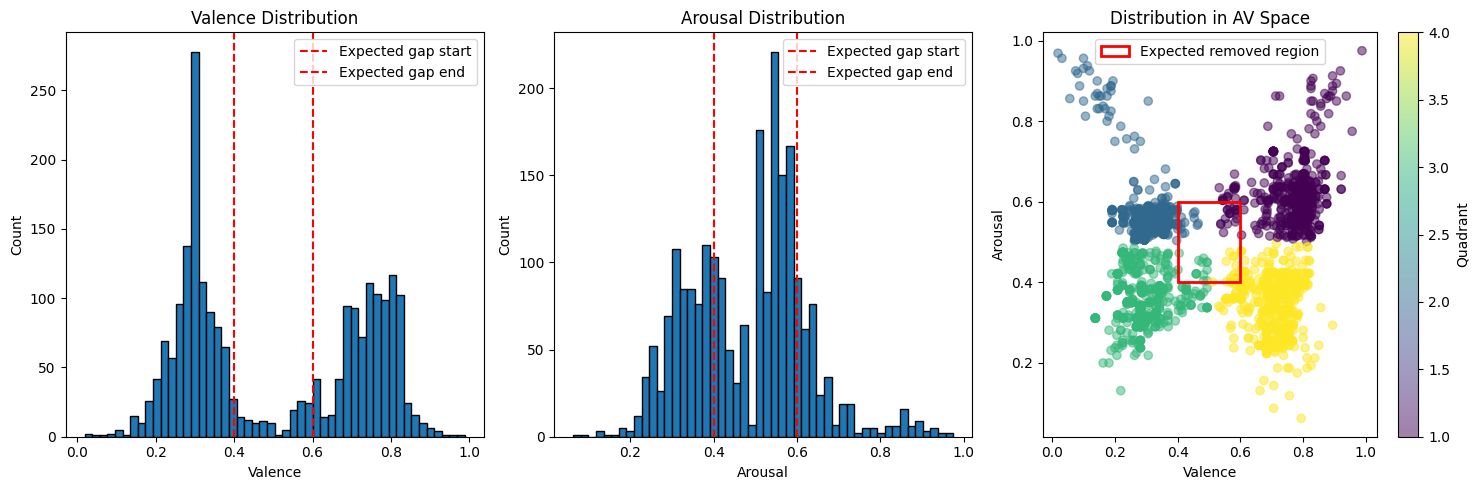


Points in center region [0.4-0.6]: 61 (2.8%)
Points in broader center [0.3-0.7]: 771 (34.8%)


In [ ]:
# Diagnostic code based on the very low MAE scores using the MERGE dataset.
# Identifying the data - Ambiguous songs are removed, so should see a doughnut shape on the scatter plot and missing sections on histograms

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#Histogram of valence - showing missing parts in the middle (0.4 to 0.6 from mappings)
axes[0].hist(master_df['valence'], bins=50, edgecolor='black')
axes[0].axvline(x=0.4, color='r', linestyle='--', label='Expected gap start')
axes[0].axvline(x=0.6, color='r', linestyle='--', label='Expected gap end')
axes[0].set_xlabel('Valence')
axes[0].set_ylabel('Count')
axes[0].set_title('Valence Distribution')
axes[0].legend()

#Histogram of arousal - showing missing parts in the middle (0.4 to 0.6 from mappings)
axes[1].hist(master_df['arousal'], bins=50, edgecolor='black')
axes[1].axvline(x=0.4, color='r', linestyle='--', label='Expected gap start')
axes[1].axvline(x=0.6, color='r', linestyle='--', label='Expected gap end')
axes[1].set_xlabel('Arousal')
axes[1].set_ylabel('Count')
axes[1].set_title('Arousal Distribution')
axes[1].legend()

#2D scatter - see hole in the middle. This dataset is no good for VA
quadrant_map = {'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4}
quadrant_numeric = master_df['quadrant'].map(quadrant_map)

scatter = axes[2].scatter(master_df['valence'], master_df['arousal'],
                         c=quadrant_numeric, cmap='viridis', alpha=0.5)
axes[2].add_patch(plt.Rectangle((0.4, 0.4), 0.2, 0.2,
                               fill=False, edgecolor='red', linewidth=2,
                               label='Expected removed region'))
axes[2].set_xlabel('Valence')
axes[2].set_ylabel('Arousal')
axes[2].set_title('Distribution in AV Space')
axes[2].legend()
plt.colorbar(scatter, ax=axes[2], label='Quadrant')

plt.tight_layout()
plt.show()

# Checking how many points fall in the "Expected to be removed" section
in_center = ((master_df['valence'] >= 0.4) & (master_df['valence'] <= 0.6) &
             (master_df['arousal'] >= 0.4) & (master_df['arousal'] <= 0.6))
print(f"\nPoints in center region [0.4-0.6]: {in_center.sum()} ({in_center.mean()*100:.1f}%)")

# Also checking just outside this area to see if any other points are affected
in_broader_center = ((master_df['valence'] >= 0.3) & (master_df['valence'] <= 0.7) &
                     (master_df['arousal'] >= 0.3) & (master_df['arousal'] <= 0.7))
print(f"Points in broader center [0.3-0.7]: {in_broader_center.sum()} ({in_broader_center.mean()*100:.1f}%)")

In [ ]:
# test on the mean and quadratn predictions

#Mean baseline
train_val_mean = train_df['valence'].mean()
train_ar_mean = train_df['arousal'].mean()
print(f"Training set means: V={train_val_mean:.3f}, A={train_ar_mean:.3f}")

#Quick quadrant check
for q in ['Q1', 'Q2', 'Q3', 'Q4']:
    q_data = train_df[train_df['quadrant'] == q]
    print(f"{q}: V={q_data['valence'].mean():.3f}±{q_data['valence'].std():.3f}, "
          f"A={q_data['arousal'].mean():.3f}±{q_data['arousal'].std():.3f}")

#How spread out are values within each quadrant?
print("\nWithin-quadrant variance:")
for q in ['Q1', 'Q2', 'Q3', 'Q4']:
    q_data = test_df[test_df['quadrant'] == q]
    print(f"{q}: V_std={q_data['valence'].std():.3f}, A_std={q_data['arousal'].std():.3f}")

Training set means: V=0.503, A=0.484
Q1: V=0.770±0.081, A=0.630±0.087
Q2: V=0.297±0.060, A=0.569±0.090
Q3: V=0.290±0.072, A=0.363±0.068
Q4: V=0.708±0.066, A=0.341±0.074

Within-quadrant variance (lower = more clustered):
Q1: V_std=0.067, A_std=0.047
Q2: V_std=0.049, A_std=0.028
Q3: V_std=0.082, A_std=0.058
Q4: V_std=0.066, A_std=0.063


In [ ]:

# Saving to CSV - copying the original CSV and adding in the results to inspect manually

print("\nSaving Detailed song by song CSV")

# new DF with the song ID arousal and valence
results_df = test_df[['song_id', 'valence', 'arousal']].copy()
results_df['valence_predicted'] = valence_pred
results_df['arousal_predicted'] = arousal_pred

# path for saving new CSV in drive
gdrive_output_path = '/content/drive/MyDrive/dissertation/merge_dataset/output_from_code/'
output_filename = 'evaluation_results_with_predictions.csv'
output_filepath = os.path.join(gdrive_output_path, output_filename)

# Save CSV file
try:
    results_df.to_csv(output_filepath, index=False)
    print(f"Successfully saved detailed results to: {output_filepath}")
except Exception as e:
    print(f"Error saving file: {e}")


Saving Detailed song by song CSV
Successfully saved detailed results to: /content/drive/MyDrive/dissertation/merge_dataset/output_from_code/evaluation_results_with_predictions.csv


In [ ]:


print("\n💾 Saving the trained model weights...")

#Define the path to save the model
save_path = '/content/drive/MyDrive/dissertation/bimodal_regression_model.pth'

#Save the parameters
torch.save(model.state_dict(), save_path)

print(f"Model saved successfully to: {save_path}")


💾 Saving the trained model weights...
Model saved successfully to: /content/drive/MyDrive/dissertation/bimodal_regression_model.pth
